# Importing the libraries

In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Getting and loading the Training and Testing set

In [2]:
path = r"C:\AI-DocHelper_Models_Code\Lung_Cancer_Detection\dataset"

In [3]:
batch_size = 16
img_size = (134, 134)

In [4]:
image_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=40.,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2, 
                                  horizontal_flip=True,
                                  fill_mode="nearest",
                                  validation_split=0.2)

In [5]:
train_generator = image_datagen.flow_from_directory(path,
                                                   target_size=img_size,
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   subset="training",
                                                   shuffle=True)

validation_generator = image_datagen.flow_from_directory(path,
                                                        target_size=img_size,
                                                        batch_size=batch_size,
                                                        class_mode="categorical",
                                                        subset="validation",
                                                        shuffle=False)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# Getting the class names

In [6]:
temp_classes = dict(train_generator.class_indices)

classes = dict()
for (k, v) in temp_classes.items():
    classes[v] = k
print(classes)

{0: 'lung_aca', 1: 'lung_n', 2: 'lung_scc'}


# Building the CNN

## Initalising the CNN

In [7]:
model = Sequential()

## Adding VGG16 as the model base

In [8]:
from tensorflow.keras.applications import VGG16

In [9]:
vgg16 = VGG16(input_shape=(img_size[0], img_size[1], 3),
             include_top = False,
             weights="imagenet")

In [10]:
for layer in vgg16.layers:
    layer.trainable= False

In [11]:
model.add(vgg16)

In [12]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 134, 134, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 134, 134, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 134, 134, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 67, 67, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 67, 67, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 67, 67, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 33, 33, 128)       0     

## Flattening all the layers

In [13]:
model.add(Flatten())

## Adding the First Fully Connected Layer

In [14]:
model.add(Dense(units=512, activation="relu"))

## Adding a Dropout layer

In [15]:
model.add(Dropout(rate=0.5))

## Adding the Final Fully Connected Layer

In [16]:
model.add(Dense(units=3, activation="sigmoid"))

## Diaplaying the model summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 18,911,043
Trainable params: 4,196,355
Non-trainable params: 14,714,688
_________________________________________________________________


# Compiling the CNN

In [18]:
model.compile(optimizer="adam",
             loss="categorical_crossentropy",
              metrics=["accuracy"])

# Training the CNN

## Saving the best model only

In [19]:
checkpoint = ModelCheckpoint(filepath="lung_cancer.h5",
                            save_best_only=True)

## Stop the training, if there is no improvement

In [20]:
earlyStopping = EarlyStopping(monitor="val_loss",
                             patience=10,
                             restore_best_weights=True,
                             verbose=1)

## Calculating the steps_per_epoch and valiadtion_steps

In [21]:
import math

batch_size=batch_size
training_size = 12000 
validation_size = 3000

compute_steps_per_epoch = lambda x : int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(training_size)
valiadtion_steps = compute_steps_per_epoch(validation_size)

print(steps_per_epoch)
print(valiadtion_steps)

750
188


In [22]:
history = model.fit(train_generator,
                   steps_per_epoch=steps_per_epoch,
                    epochs=30,
                   validation_data=validation_generator,
                   validation_steps=valiadtion_steps,
                   callbacks=[checkpoint, earlyStopping])

Epoch 1/30
750/750 [==============================] - 790s 1s/step - loss: 0.5152 - accuracy: 0.8308 - val_loss: 0.1566 - val_accuracy: 0.9393
Epoch 2/30
750/750 [==============================] - 755s 1s/step - loss: 0.2281 - accuracy: 0.9097 - val_loss: 0.1961 - val_accuracy: 0.9190
Epoch 3/30
750/750 [==============================] - 808s 1s/step - loss: 0.2324 - accuracy: 0.9060 - val_loss: 0.1456 - val_accuracy: 0.9410
Epoch 4/30
750/750 [==============================] - 758s 1s/step - loss: 0.2083 - accuracy: 0.9177 - val_loss: 0.1529 - val_accuracy: 0.9373
Epoch 5/30
750/750 [==============================] - 768s 1s/step - loss: 0.2037 - accuracy: 0.9199 - val_loss: 0.1510 - val_accuracy: 0.9387
Epoch 6/30
750/750 [==============================] - 733s 978ms/step - loss: 0.1851 - accuracy: 0.9268 - val_loss: 0.1396 - val_accuracy: 0.9470
Epoch 7/30
750/750 [==============================] - 773s 1s/step - loss: 0.1774 - accuracy: 0.9300 - val_loss: 0.1404 - val_accuracy: 0.9

# Saving the model

In [23]:
model_json = model.to_json()

with open("lung_cancer.json", "w") as json_file :
    json_file.write(model_json)

# Visualizing the training performance

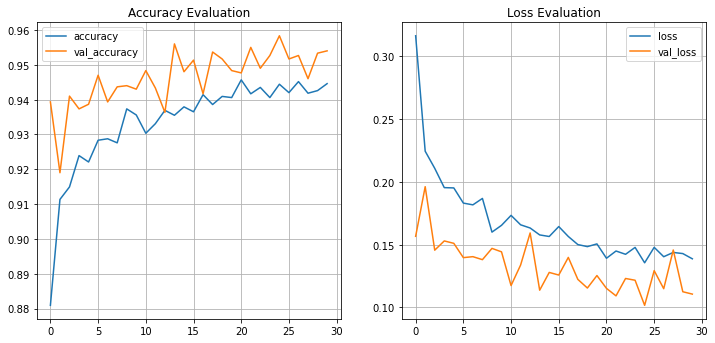

In [25]:
plt.figure(figsize = (12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.legend()
plt.grid()
plt.title("Accuracy Evaluation")

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.grid()
plt.legend()
plt.title("Loss Evaluation")

plt.savefig("lung_cancer_model_history.jpg")

# Getting the accuracy for test set

In [26]:
test_accuracy = model.evaluate(validation_generator)
print(test_accuracy)

188/188 [==============================] - 155s 824ms/step - loss: 0.1160 - accuracy: 0.9527
[0.11604411154985428, 0.9526666402816772]


In [27]:
preds = model.predict(validation_generator, verbose=1)
preds

188/188 [==============================] - 150s 797ms/step


array([[8.0999529e-01, 3.8580000e-03, 8.0437273e-01],
       [9.9999273e-01, 6.2891777e-05, 6.4224148e-01],
       [9.8983639e-01, 2.2047371e-02, 3.0266148e-01],
       ...,
       [9.7677064e-01, 9.1324145e-30, 9.9999923e-01],
       [9.5235622e-01, 4.3371898e-25, 9.9999189e-01],
       [9.5811707e-01, 1.3749644e-23, 9.9998534e-01]], dtype=float32)

In [28]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [29]:
print(predictions)

[[1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]]
